### 尝试不同optimizer对模型进行训练，观察对比loss结果



In [2]:
import torch
import torch.nn as nn

from sklearn.datasets import fetch_olivetti_faces


In [3]:
# 加载数据集  ​​40 个不同个体​​，每人 ​​10 张人脸图像​​，共 ​​400 张图像​​，以灰度图形式存储
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)
images = torch.tensor(olivetti_faces.data) # 400*4096
targets = torch.tensor(olivetti_faces.target) # 400
dataset = [(img,lbl) for img,lbl in zip(images, targets)]  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True) # 创建数据加载器

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_model_objects(optim_strategy):
    # 多层神经网络模型
    model = nn.Sequential(
        nn.Linear(4096, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(8192, 16384),
        nn.BatchNorm1d(16384),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(16384, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(),
        
        nn.Linear(1024, 40)
    ).to(device)  # 将模型移动到 GPU 上,如果可用的话

    criterion = nn.CrossEntropyLoss()  # 损失函数
    if optim_strategy == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    elif optim_strategy == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    elif optim_strategy == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Invalid optimization strategy")
    return model, criterion, optimizer

错误信息 RuntimeError: expected scalar type Long but found Int   
在调用 cross_entropy 损失函数时，目标标签 target 应当是 Long 类型，然而实际传入的却是 Int 类型

In [8]:
loss_hist = {}

for optimizer_name in ['SGD', 'RMSprop', 'Adam']:

    model, criterion, optimizer = build_model_objects(optimizer_name)
    loss_hist[optimizer_name] = []
    model.to(device)  # 模型搬到GPU内存中

    model.train()
    for i in range(20):
        for img,lbl in dataloader:
            img,lbl = img.to(device), lbl.to(device)  # 数据和模型在同一个设备端
            result = model(img)
            loss = criterion(result, lbl.long()) # lbl.long()将标签转换为 torch.long 类型
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist[optimizer_name].append(loss.item())
            print(f'epoch:{i+1} optimizer:{optimizer_name} loss:{loss.item():.4f}')

epoch:1 optimizer:SGD loss:3.5172
epoch:1 optimizer:SGD loss:3.8569
epoch:1 optimizer:SGD loss:3.6309
epoch:1 optimizer:SGD loss:3.7641
epoch:1 optimizer:SGD loss:3.9977
epoch:1 optimizer:SGD loss:3.7396
epoch:1 optimizer:SGD loss:3.7092
epoch:1 optimizer:SGD loss:3.6514
epoch:1 optimizer:SGD loss:3.7845
epoch:1 optimizer:SGD loss:3.8415
epoch:1 optimizer:SGD loss:3.8542
epoch:1 optimizer:SGD loss:3.8465
epoch:1 optimizer:SGD loss:3.5673
epoch:1 optimizer:SGD loss:3.8966
epoch:1 optimizer:SGD loss:3.6320
epoch:1 optimizer:SGD loss:3.8795
epoch:1 optimizer:SGD loss:3.6654
epoch:1 optimizer:SGD loss:3.4349
epoch:1 optimizer:SGD loss:3.6196
epoch:1 optimizer:SGD loss:3.3935
epoch:1 optimizer:SGD loss:3.7897
epoch:1 optimizer:SGD loss:3.7845
epoch:1 optimizer:SGD loss:3.9316
epoch:1 optimizer:SGD loss:3.4946
epoch:1 optimizer:SGD loss:3.6618
epoch:1 optimizer:SGD loss:3.5789
epoch:1 optimizer:SGD loss:3.7739
epoch:1 optimizer:SGD loss:3.6702
epoch:1 optimizer:SGD loss:3.4423
epoch:1 optimi

In [5]:
# loss_hist = []

# for i in range(10):
#     for img,lbl in dataloader:
#         img,lbl = img.to(device), lbl.to(device)  # 数据和模型在同一个设备端
#         lbl = lbl.long()  # 将标签转换为 Long 类型 <<< 核心修复点
#         result = model(img)
#         loss = criterion(result, lbl)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         loss_hist.append(loss.item())
#         print(f'epoch:{i+1} loss:{loss.item():.4f}')

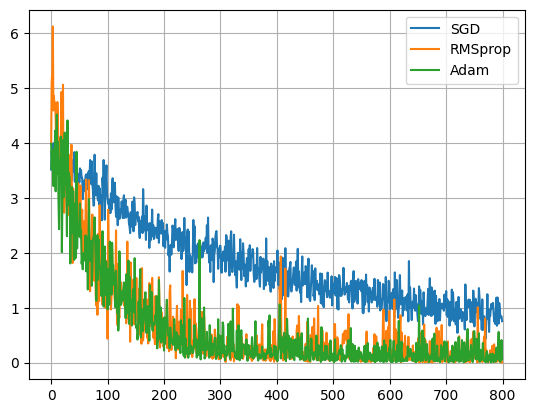

In [9]:
import matplotlib.pyplot as plt

for opt in ['SGD', 'RMSprop', 'Adam']:
    plt.plot(range(len(loss_hist[opt])), loss_hist[opt], label=opt)
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格
plt.show() # 触发图像的显示​​